# Multilabel Text Classification

## Setting Up Necessary Things

In [ ]:
# Jupyter Notebook Magic Command - Auto Reloading
%reload_ext autoreload
%autoreload 2

# Jupyter Notebook Magic Command - Inline Plotting
%matplotlib inline

In [ ]:
# Ignore All Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# NVIDIA Status
! nvidia-smi

Tue Aug 29 17:02:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TC.Video.Game

/content/drive/MyDrive/TC.Video.Game


## Necessary Imports

In [ ]:
! pip install -q transformers sentencepiece fastbook fastai ohmeow-blurr nbdev

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

## Data Cleaning

In [ ]:
# Load Data Into DataFrame
df = pd.read_csv("data/raw_data/game_details_original.csv")
df.head()

,Name,Summary,Genres
0,The Legend of Zelda: Ocarina of Time,"As a young boy, Link is tricked by Ganondorf, the King of the Gerudo Thieves. The evil human uses Link to gain access to the Sacred Realm, where he places his tainted hands on Triforce and transforms the beautiful Hyrulean landscape into a barren wasteland. Link is determined to fix the problems he helped to create, so with the help of Rauru he travels through time gathering the powers of the Seven Sages.","['Action Adventure', 'Fantasy']"
1,Tony Hawk's Pro Skater 2,"As most major publishers' development efforts shift to any number of next-generation platforms, Tony Hawk 2 will likely stand as one of the last truly fantastic games to be released on the PlayStation.","['Sports', 'Alternative', 'Skateboarding']"
2,Grand Theft Auto IV,"[Metacritic's 2008 PS3 Game of the Year; Also known as ""GTA IV""] What does the American Dream mean today? For Niko Belic, fresh off the boat from Europe. It's the hope he can escape his past. For his cousin, Roman, it is the vision that together they can find fortune in Liberty City, gateway to the land of opportunity. As they slip into debt and are dragged into a criminal underworld by a series of shysters, thieves and sociopaths, they discover that the reality is very different from the dream in a city that worships money and status, and is heaven for those who have them an a living nigh...","['Action Adventure', 'Modern', 'Modern', 'Open-World']"
3,SoulCalibur,"This is a tale of souls and swords, transcending the world and all its history, told for all eternity... The greatest weapons-based fighter returns, this time on Sega Dreamcast. Soul Calibur unleashes incredible graphics, fantastic fighters, and combos so amazing they'll make your head spin!","['Action', 'Fighting', '3D']"
4,Grand Theft Auto IV,"[Metacritic's 2008 Xbox 360 Game of the Year; Also known as ""GTA IV""] What does the American Dream mean today? For Niko Belic, fresh off the boat from Europe. It's the hope he can escape his past. For his cousin, Roman, it is the vision that together they can find fortune in Liberty City, gateway to the land of opportunity. As they slip into debt and are dragged into a criminal underworld by a series of shysters, thieves and sociopaths, they discover that the reality is very different from the dream in a city that worships money and status, and is heaven for those who have them an a living...","['Action Adventure', 'Modern', 'Modern', 'Open-World']"


In [ ]:
# Shape of the DataFrame
df.shape

(20406, 3)

In [ ]:
genres_list = df["Genres"].to_list()    # list of all the genres
genres_count = {}                       # count of all the genres

for genres in genres_list:
  try:
    genre_list = eval(genres)

    for genre in genre_list:
      if genre in genres_count.keys():
        genres_count[genre] += 1
      else:
        genres_count[genre] = 1
  except:
    continue

In [ ]:
print("Total Number of Genres: ", len(genres_count))

sorted_genres_count = dict(sorted(genres_count.items(), key=lambda item: item[1], reverse=True))
print("Individual Genres Count: \n", sorted_genres_count)

Total Number of Genres:  178
Individual Genres Count: 
 {'Action': 7097, 'General': 7035, 'Shooter': 3549, 'Action Adventure': 3424, 'Platformer': 2371, 'Arcade': 2355, 'Role-Playing': 2341, '3D': 2127, 'Adventure': 1995, '2D': 1979, 'Miscellaneous': 1927, 'Strategy': 1905, 'First-Person': 1875, 'Sci-Fi': 1779, 'Fantasy': 1729, 'Sports': 1727, 'Modern': 1569, 'Puzzle': 1376, 'Action RPG': 1300, 'Racing': 1239, 'Sim': 1162, 'Simulation': 1160, 'Third-Person': 1040, 'Traditional': 1015, 'Driving': 971, 'Historic': 915, 'Fighting': 838, 'Automobile': 782, 'Real-Time': 772, 'Turn-Based': 740, 'Open-World': 736, "Beat-'Em-Up": 713, 'Team': 619, 'Compilation': 546, 'Survival': 544, 'Individual': 450, "Shoot-'Em-Up": 433, 'Point-and-Click': 430, 'Horror': 419, 'Japanese-Style': 415, 'Music': 411, 'Tactical': 405, 'Tactics': 392, 'Combat': 382, 'Linear': 353, 'Console-style RPG': 346, 'Rhythm': 340, 'Management': 334, 'GT / Street': 283, 'Western-Style': 279, 'Soccer': 276, 'Scrolling': 264, '

### Removing Rare Genres

In [ ]:
threshold = int(len(df) * 0.075)

rare_genres = [item for item, count in genres_count.items() if count < threshold]

print("Total Rare Genres: ", len(rare_genres))
print("Rare Genres: ", rare_genres)

Total Rare Genres:  161
Rare Genres:  ['Alternative', 'Skateboarding', 'Open-World', 'Fighting', 'Western-Style', 'Traditional', 'Football', 'Sim', 'Linear', 'Horror', 'Compilation', 'Action RPG', 'Visual Novel', 'Driving', 'Racing', 'GT / Street', 'PC-style RPG', 'Third-Person', 'Historic', 'Japanese-Style', 'Puzzle', 'Stacking', 'Console-style RPG', 'Survival', 'Turn-Based', '4X', 'Real-Time', 'Roguelike', 'Simulation', 'Management', 'Government', '', 'Metroidvania', 'Command', 'Snowboarding', 'Sandbox', 'Soccer', 'Kart', 'Rhythm', 'Music', "Beat-'Em-Up", 'Basketball', 'Application', 'Automobile', 'Ice Hockey', 'Virtual Life', 'Virtual', 'Wargame', 'Team', 'Tactical', 'Tennis', 'Tactics', 'Point-and-Click', 'Snow / Water', 'Massively Multiplayer', 'Flight', 'Civilian', 'Massively Multiplayer Online', 'Board / Card Game', 'Card Battle', 'Formula One', 'WWII', 'Combat', 'Space', 'Small Spaceship', 'Car Combat', 'Baseball', 'Individual', 'Golf', 'Skate / Skateboard', 'Motorcycle', 'Stre

In [ ]:
genres_list = df["Genres"].to_list()
revised_genre_list = []
indices_to_drop = []

for idx, genres in enumerate(genres_list):
  try:
    genre_list = eval(genres)
    revised_genres = []

    for genre in genre_list:
      if genre not in rare_genres:
        revised_genres.append(genre)

    if len(revised_genres) == 0:
      indices_to_drop.append(idx)
    else:
      revised_genres_set = set(revised_genres)
      revised_genre_list.append(list(revised_genres_set))
  except:
    indices_to_drop.append(idx)

In [ ]:
df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(18761, 3)

In [ ]:
df["Revised Genres"] = revised_genre_list

In [ ]:
revised_genres_list = df["Revised Genres"].to_list()
revised_genre_count = {}

for genres in revised_genres_list:
  genre_list = genres

  for genre in genre_list:
    if genre in revised_genre_count.keys():
      revised_genre_count[genre] += 1
    else:
      revised_genre_count[genre] = 1

In [ ]:
print("Total Number of Revised Genres: ", len(revised_genre_count))

sorted_revised_genre_count = dict(sorted(revised_genre_count.items(), key=lambda item: item[1], reverse=True))
print("Individual Revised Genres Count: \n", sorted_revised_genre_count)

Total Number of Revised Genres:  17
Individual Revised Genres Count: 
 {'Action': 7037, 'General': 5579, 'Action Adventure': 3424, 'Shooter': 2513, 'Role-Playing': 2341, 'Arcade': 2186, 'Adventure': 1995, 'Miscellaneous': 1927, 'Strategy': 1905, 'Platformer': 1867, '3D': 1818, 'First-Person': 1811, 'Sports': 1727, '2D': 1590, 'Sci-Fi': 1140, 'Fantasy': 1092, 'Modern': 998}


In [ ]:
encode_genre_types = { key: idx for idx, (key, value) in enumerate(revised_genre_count.items())}

with open("json_files/original/genre_types_encoded_original.json", "w") as fp:
  json.dump(encode_genre_types, fp)

In [ ]:
encode_genre_types

{'Action Adventure': 0,
 'Fantasy': 1,
 'Sports': 2,
 'Modern': 3,
 '3D': 4,
 'Action': 5,
 'Platformer': 6,
 'General': 7,
 'Role-Playing': 8,
 'Shooter': 9,
 'First-Person': 10,
 'Sci-Fi': 11,
 'Arcade': 12,
 'Miscellaneous': 13,
 'Adventure': 14,
 '2D': 15,
 'Strategy': 16}

In [ ]:
# We need this because for multilabel classification all genres have possibility to be present in the predictions
categorical_genre_list = []
revised_genres_list = df["Revised Genres"].to_list()

for revised_genres in revised_genres_list:
  categorical_list = [0] * len(encode_genre_types)

  for genre in revised_genres:
    if genre in encode_genre_types:
      genre_type_index = encode_genre_types[genre]
      categorical_list[genre_type_index] = 1

  categorical_genre_list.append(categorical_list)

categorical_genre_list[3][:23]

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
df["Genre Cat List"] = categorical_genre_list

In [ ]:
df.head()

,Name,Summary,Genres,Revised Genres,Genre Cat List
0,The Legend of Zelda: Ocarina of Time,"As a young boy, Link is tricked by Ganondorf, the King of the Gerudo Thieves. The evil human uses Link to gain access to the Sacred Realm, where he places his tainted hands on Triforce and transforms the beautiful Hyrulean landscape into a barren wasteland. Link is determined to fix the problems he helped to create, so with the help of Rauru he travels through time gathering the powers of the Seven Sages.","['Action Adventure', 'Fantasy']","[Action Adventure, Fantasy]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Tony Hawk's Pro Skater 2,"As most major publishers' development efforts shift to any number of next-generation platforms, Tony Hawk 2 will likely stand as one of the last truly fantastic games to be released on the PlayStation.","['Sports', 'Alternative', 'Skateboarding']",[Sports],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Grand Theft Auto IV,"[Metacritic's 2008 PS3 Game of the Year; Also known as ""GTA IV""] What does the American Dream mean today? For Niko Belic, fresh off the boat from Europe. It's the hope he can escape his past. For his cousin, Roman, it is the vision that together they can find fortune in Liberty City, gateway to the land of opportunity. As they slip into debt and are dragged into a criminal underworld by a series of shysters, thieves and sociopaths, they discover that the reality is very different from the dream in a city that worships money and status, and is heaven for those who have them an a living nigh...","['Action Adventure', 'Modern', 'Modern', 'Open-World']","[Action Adventure, Modern]","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,SoulCalibur,"This is a tale of souls and swords, transcending the world and all its history, told for all eternity... The greatest weapons-based fighter returns, this time on Sega Dreamcast. Soul Calibur unleashes incredible graphics, fantastic fighters, and combos so amazing they'll make your head spin!","['Action', 'Fighting', '3D']","[3D, Action]","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Grand Theft Auto IV,"[Metacritic's 2008 Xbox 360 Game of the Year; Also known as ""GTA IV""] What does the American Dream mean today? For Niko Belic, fresh off the boat from Europe. It's the hope he can escape his past. For his cousin, Roman, it is the vision that together they can find fortune in Liberty City, gateway to the land of opportunity. As they slip into debt and are dragged into a criminal underworld by a series of shysters, thieves and sociopaths, they discover that the reality is very different from the dream in a city that worships money and status, and is heaven for those who have them an a living...","['Action Adventure', 'Modern', 'Modern', 'Open-World']","[Action Adventure, Modern]","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
# Drop Duplicate Summary from the DataFrame
df = df.drop_duplicates(subset = "Summary", keep='first')

In [ ]:
# Drop Genres Column
df.drop(["Genres"], axis = 1, inplace = True)

In [ ]:
df = df.dropna().reset_index(drop=True)

In [ ]:
df.isna().sum()

Name              0
Summary           0
Revised Genres    0
Genre Cat List    0
dtype: int64

In [ ]:
# Shuffle DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Description of The DataFrame
df.describe(include="object")

,Name,Summary,Revised Genres,Genre Cat List
count,14657,14657,14657,14657
unique,12152,14657,348,324
top,Grand Theft Auto V,"Railbound is a comfy track-bending puzzle game about a pair of dogs on a train journey around the world. Connect and sever railways across the world to help everyone reach their homes, and solve over 150 clever puzzles ranging from gentle slopes to twisted passageways.",[Role-Playing],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
freq,6,1,1132,1132


## Data-Loaders and Modeling

In [ ]:
labels = list(encode_genre_types.keys())

In [ ]:
model_name = "distilroberta-base"

model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)

hf_model.config.problem_type = "multi_label_classification"

In [ ]:
blocks = (
    TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model),
    MultiCategoryBlock(encoded=True,vocab=labels)
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("Summary"),
    get_y=ColReader("Genre Cat List"),
    splitter=RandomSplitter(valid_pct=0.1, seed=42)
)

In [ ]:
dls = dblock.dataloaders(df, bs=32)

torch.save(dls, "dataloaders/original/dls-multilabel-game-classifier-original.pkl")

In [ ]:
dls.vocab

['Action Adventure', 'Fantasy', 'Sports', 'Modern', '3D', 'Action', 'Platformer', 'General', 'Role-Playing', 'Shooter', 'First-Person', 'Sci-Fi', 'Arcade', 'Miscellaneous', 'Adventure', '2D', 'Strategy']

In [ ]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,"In The Eternal Cylinder, players control a herd of adorable creatures called Trebhums and must explore a strange alien world filled with exotic lifeforms, surreal environments, and the constant threat of the Cylinder, a gargantuan rolling structure of ancient origin which crushes everything in its path. This unique ecosystem is a massive, procedurally generated land with unique animal AI, real-time world destruction, and organic exploration and puzzle design to create emergent gameplay that ensures no two",[Action Adventure]
1,"You are Geralt of Rivia, mercenary monster slayer. Before you stands a war-torn, monster-infested continent you can explore at will. Your current contract? Tracking down Ciri — the Child of Prophecy, a living weapon that can alter the shape of the world. The Complete Edition contains the base game, offering a huge, over 100-hour long, open-world adventure, as well as both of its massive story expansions: Hearts of Stone & Blood and Wine worth an extra 50 hours of gameplay! It also comes with all additional",[Role-Playing]
2,"Lemnis Gate is a time-warping, turn-based combat strategy FPS. Over five alternating turns taking place in a 25” time-loop, you are called to master the unique abilities of a varied cast of deep-space operatives and outskill, outsmart, and outmanoeuvre your opponent in mind-bending four-dimensional battles. Lemnis Gate twists time to subvert one of the world’s most popular game genres and offers a relentlessly inventive multiplayer experience deeply rooted in tactical FPS gameplay. Challenge yourself to th","[Action, Shooter, First-Person, Arcade]"
3,"Get ready for the GREATEST platformer with the most responsive controls to hit the App Store yet!The world needs your help! Evil scientists worldwide have joined forces forming a ""League of Evil""; the only super agent who can stop them is YOU!As a specially trained agent you can double jump, flipping your way over obstacles. You are also trained in wall jumping gaps to reach new heights. So get ready to show your sick acrobatic moves across 160 challenging levels! Fight your way through your mission and fi","[Modern, Strategy]"


In [ ]:
doc(accuracy_multi)

In [ ]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[acc_02],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter
).to_fp16()

## Stage: 0

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.0014454397605732083, valley=0.00013182566908653826)

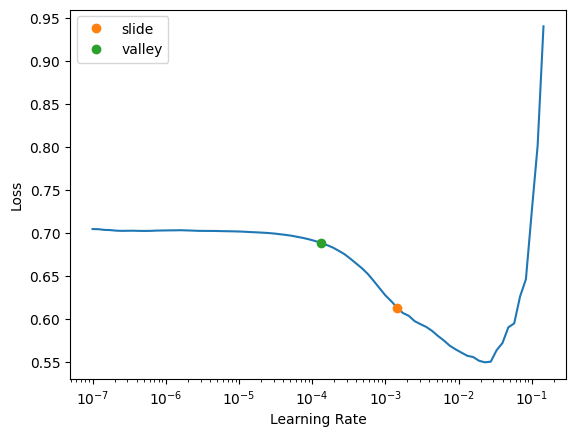

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(1, 5.75e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.359258,0.360506,0.830235,00:53


In [ ]:
learner.save("original/game-ml-classifier-stage-original-0")

Path('models/original/game-ml-classifier-stage-original-0.pth')

In [ ]:
learner.export("models/original/game-ml-classifier-stage-original-0.pkl")

## Stage: 1

In [ ]:
learner.unfreeze()

SuggestedLRs(slide=0.0014454397605732083, valley=2.0892961401841603e-05)

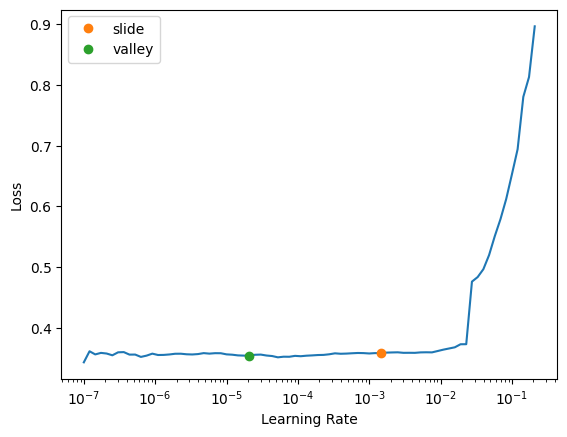

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(3,slice(1.75e-3, 1.75e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.358620,0.361544,0.830235,01:13
1,0.363374,0.360399,0.830235,01:12
2,0.359411,0.360323,0.830235,01:13


In [ ]:
learner.save("original/game-ml-classifier-stage-original-1")

Path('models/original/game-ml-classifier-stage-original-1.pth')

In [ ]:
learner.export("models/original/game-ml-classifier-stage-original-1.pkl")

## Data Split

In [ ]:
splitter = RandomSplitter(valid_pct=0.1, seed=42)

train_ids, valid_ids = splitter(df)

print("Train Len: ", len(train_ids))
print("Valid Len: ", len(valid_ids))

Train Len:  13192
Valid Len:  1465


In [ ]:
valid_df = df.loc[valid_ids]

print("Valid Data: ")
valid_df.head()

Valid Data: 


,Name,Summary,Revised Genres,Genre Cat List
2478,Unbound: Worlds Apart,"Explore beautiful, hand-crafted Metroidvanian worlds by conjuring different magic portals. Each portal gives you unique abilities to solve puzzles, outsmart abominable creatures, and unravel mysteries.","[Shooter, Action]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
5300,Peggle,"[Playstation Network] The PlayStation Network edition of Peggle brings all the compelling gameplay action of the original PC version, including 55 levels of ball-bouncing madness, 10 unlockable Peggle Masters, Quick Play mode, Duel mode, and 75 Challenge mode levels. For non-stop competitive action, players can choose from two multiplayer options: two-player Duel mode, or Peg Party mode, where up to four players can compete against one another simultaneously. [PopCap Games]","[Action Adventure, Modern]","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8193,Sid Meier's Alpha Centauri,"Legendary designer Sid Meier presents the next evolution in strategy games, with the most addictive, compelling gameplay yet. Explore the alien planet that is your new home and uncover its myriad mysteries. Discover over 75 extraordinary technologies. Build over 60 base upgrades and large-scale secret projects for your empire. Conquer your enemies with a war machine that you design from over 32,000 possible unit types. [Firaxis]","[General, Role-Playing]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
3415,Pokemon Ultra Moon,"A new light shines on the Alola region. Take on the role of a Pokemon Trainer and uncover new tales, and unravel the mystery behind the two forms reminiscent of the Legendary Pokemon. With new story additions and features this earns Pokemon Ultra Sun and Pokemon Ultra Moon the name ""Ultra!"" Another adventure is about to begin. New Pokemon forms have been discovered in the Aloha region in Pokemon Ultra Sun and Pokemon Ultra Moon. These forms are reminiscent of the Legendary Pokemon Solgaleo, Lunala, and Necrozma, first revealed in Pokemon Sun and Pokemon Moon. Head out on an epic journey as...","[First-Person, Action Adventure, General, Action, Arcade, Sci-Fi, Shooter]","[1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]"
962,Mech Platoon,"The wise men say ""there is no end to the truth."" In this war-town place, there are two things without end - the universe and greed. Glittering stars give the impression of eternal serenity, but the reality is that they hide a lie. Among them blazes an endless war over limited resources; skirmishes that grow as the universe expands.","[General, Adventure]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]"


## Evaluation

In [ ]:
! pip install -q ohmeow-blurr

In [ ]:
learner_inf = learner

In [ ]:
from sklearn import metrics

def metric_measures(test_df, preds):

  targets = [np.asarray(target) for target in test_df['Genre Cat List'].to_list()]
  outputs = [np.asarray(pred) for pred in preds]


  accuracy = metrics.accuracy_score(targets, outputs)
  f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
  f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

  print(f"F1 Score (Micro) = {f1_score_micro}")
  print(f"F1 Score (Macro) = {f1_score_macro}")

  return

In [ ]:
from tqdm.notebook import tqdm

preds = []
for idx, row in tqdm(valid_df.iterrows(), total=len(valid_df)):
  desc = row['Summary']
  labels = learner_inf.blurr_predict(desc)[0]['labels']
  pred_genres = [0] * len(encode_genre_types)
  for label in labels:
    pred_genres[encode_genre_types[label]] = 1
  preds.append(pred_genres)

preds[0][:20]

  0%|          | 0/1465 [00:00<?, ?it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
print(preds[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
metric_measures(valid_df, preds)

F1 Score (Micro) = 0.0
F1 Score (Macro) = 0.0
